In [5]:
import pandas as pd
import numpy as np

# 데이터 시각화 패키지
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# 가설검정 및 통계 분석 패키지
from scipy import stats

# 선형모델 formula ( y ~ x1 + x2 + ...)
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

from sklearn.linear_model import LinearRegression
from statsmodels.api import qqplot, add_constant

from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.anova import anova_lm

# 변수 선택법(후진제거법)
from sklearn.feature_selection import RFE

# 다중공선성 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Scale변환 -> 표준화 회귀계수 산출
## coefficient를 표준화해서 비교해본다.
from sklearn.preprocessing import StandardScaler

# 주피터 노트북 사용시 그래프 자동 출력 옵션
%matplotlib inline

matplotlib.rc('font', family = "NanumGothic")
plt.rc('font', family = "NanumGothic")
plt.rcParams["font.family"] = 'NanumGothic'

## 1. 데이터 구성하기

- 감독자의 체질검사 데이터이다. **체질 비만도**를 예측하기 위한 회귀분석을 실시하고 결과를 해석

In [2]:
df_raw = pd.read_csv("./Data/체질검사.csv", engine="python")
df_raw.head()

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
0,35.2,46,363.15,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4
1,11.8,27,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8
2,22.2,69,177.75,68.50,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8
3,10.6,57,147.75,65.75,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9
4,47.5,51,219.00,64.00,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4


In [3]:
# 데이터의 특성 파악
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   FAT      252 non-null    float64
 1   AGE      252 non-null    int64  
 2   WEIGHT   252 non-null    float64
 3   HEIGHT   252 non-null    float64
 4   NECK     252 non-null    float64
 5   CHEST    252 non-null    float64
 6   ABDOMEN  252 non-null    float64
 7   HIP      252 non-null    float64
 8   THIGH    252 non-null    float64
 9   KNEE     252 non-null    float64
 10  ANKLE    252 non-null    float64
 11  BICEPS   252 non-null    float64
 12  FOREARM  252 non-null    float64
 13  WRIST    252 non-null    float64
dtypes: float64(13), int64(1)
memory usage: 27.7 KB


## 2. 데이터 분포 확인

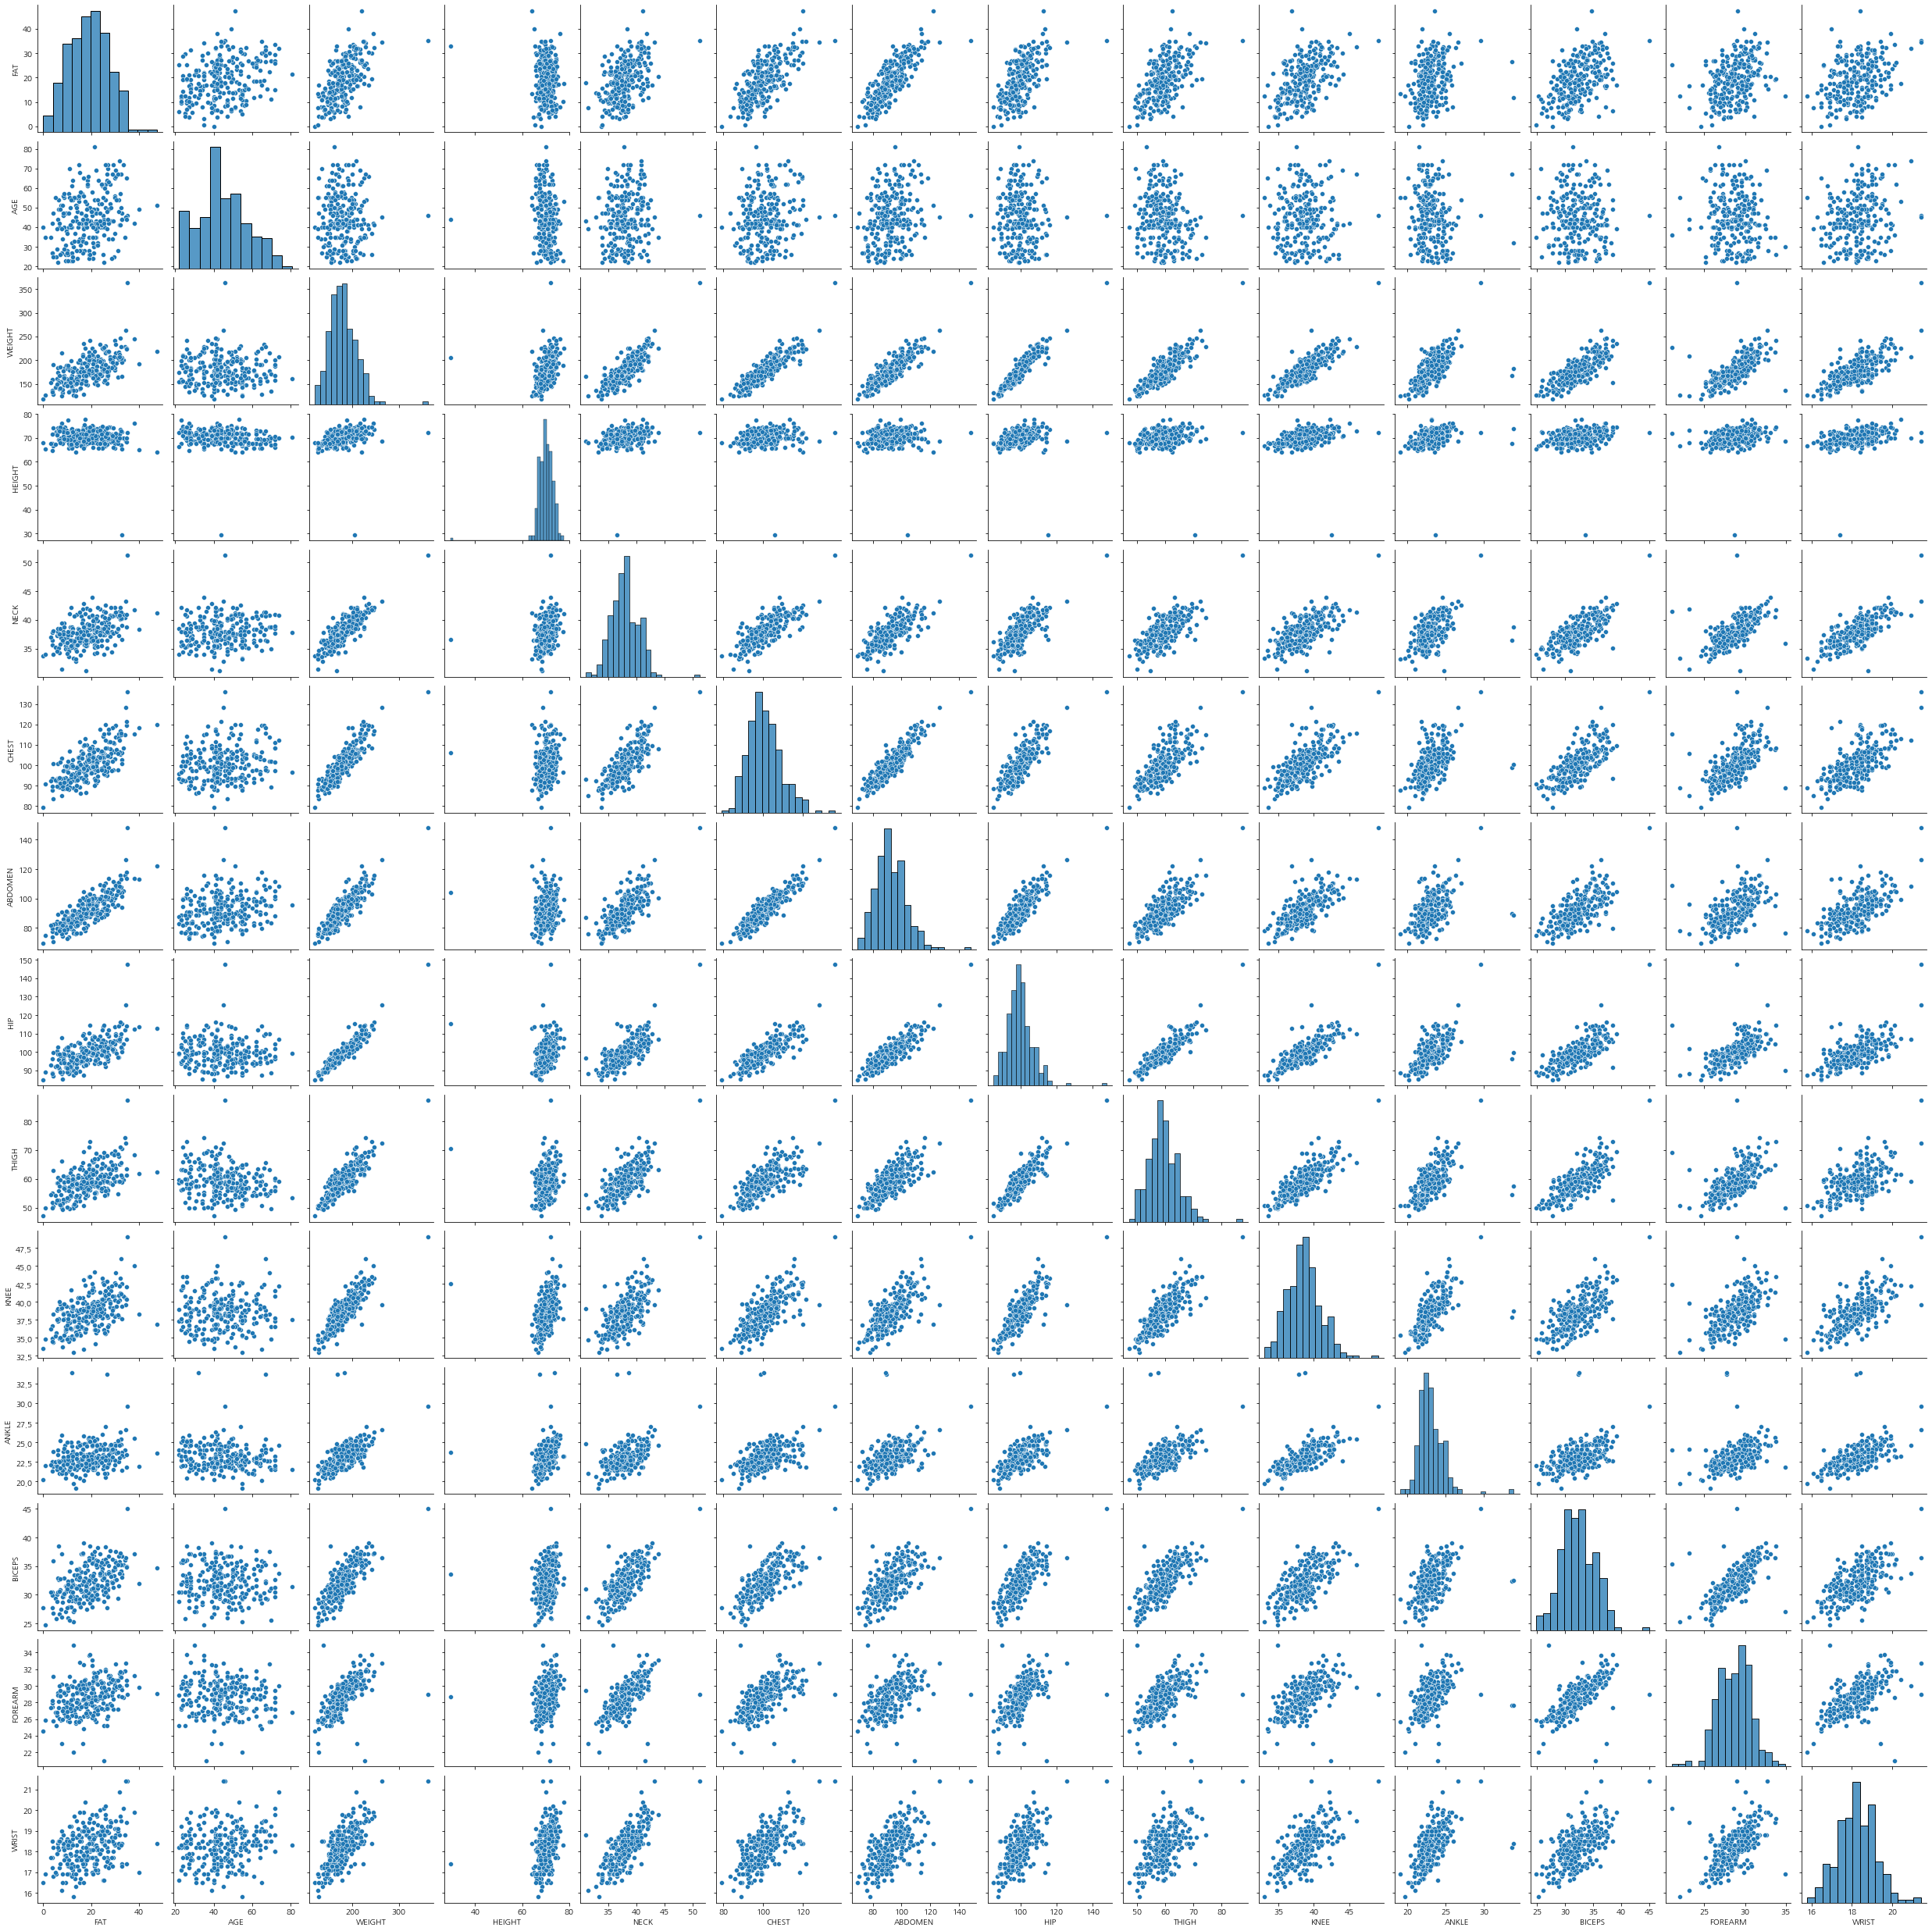

In [6]:
sns.pairplot(df_raw)

# X와 X들의 관계가 있는 것은 다중 공선성이 있다고 볼 수 있다.


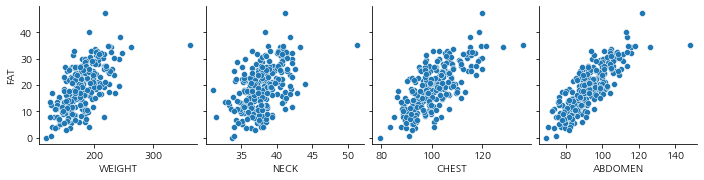

In [12]:
# 만약 관계가 있다고 판단되면 여러 개의 변수를 빼서 scatterplot을 그릴 수 있다.
sns.pairplot(df_raw, y_vars="FAT", x_vars=["WEIGHT", "NECK", "CHEST", "ABDOMEN"], diag_kind = None)

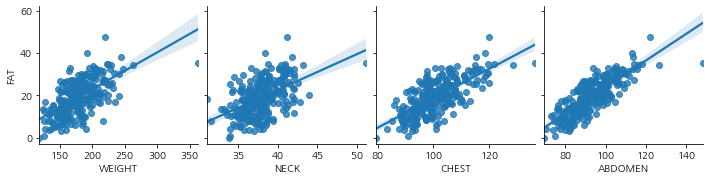

In [11]:
# kind = "reg" 회귀선 추가
sns.pairplot(df_raw, y_vars="FAT", x_vars=["WEIGHT", "NECK", "CHEST", "ABDOMEN"],\
            kind="reg", diag_kind = None)

In [9]:
# scatter plot에서 본 관계를 정량화해서 보여준다.

df_raw.corr().round(3)

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
FAT,1.000,0.291,0.612,-0.089,0.491,0.703,0.813,0.625,0.560,0.509,0.266,0.493,0.361,0.347
AGE,0.291,1.000,-0.013,-0.172,0.114,0.176,0.230,-0.050,-0.200,0.018,-0.105,-0.041,-0.085,0.214
WEIGHT,0.612,-0.013,1.000,0.308,0.831,0.894,0.888,0.941,0.869,0.853,0.614,0.800,0.630,0.730
HEIGHT,-0.089,-0.172,0.308,1.000,0.254,0.135,0.088,0.170,0.148,0.286,0.265,0.208,0.229,0.322
NECK,0.491,0.114,0.831,0.254,1.000,0.785,0.754,0.735,0.696,0.672,0.478,0.731,0.624,0.745
CHEST,0.703,0.176,0.894,0.135,0.785,1.000,0.916,0.829,0.730,0.719,0.483,0.728,0.580,0.660
ABDOMEN,0.813,0.230,0.888,0.088,0.754,0.916,1.000,0.874,0.767,0.737,0.453,0.685,0.503,0.620
HIP,0.625,-0.050,0.941,0.170,0.735,0.829,0.874,1.000,0.896,0.823,0.558,0.739,0.545,0.630
THIGH,0.560,-0.200,0.869,0.148,0.696,0.730,0.767,0.896,1.000,0.799,0.540,0.761,0.567,0.559
KNEE,0.509,0.018,0.853,0.286,0.672,0.719,0.737,0.823,0.799,1.000,0.612,0.679,0.556,0.665


## 3. 회귀모델 생성
- 선형회귀분석: 이용

In [ ]:
df_raw_y = df_raw["FAT"]
df_raw_X = df_raw.drop("FAT", axis = 1, inplace = False)

In [10]:
formula = "FAT ~ AGE+ WEIGHT + HEIGHT + NECK + CHEST + ABDOMEN + HIP \
            + THIGH + KNEE + ANKLE + BICEPS + FOREARM + WRIST"
reg_model = smf.ols(formula, data = df_raw)

# 모델(적합)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     54.65
Date:                Tue, 02 Mar 2021   Prob (F-statistic):           7.72e-64
Time:                        09:39:53   Log-Likelihood:                -718.25
No. Observations:                 252   AIC:                             1465.
Df Residuals:                     238   BIC:                             1514.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -18.1885     17.349     -1.048      0.2

- 절편의 p-value는 신경쓰지 않는다.


- 다중선형회귀에서는 Adj, R-squared로 봐야 한다.
- F-통계량값이 54 정도 되기 때문에 p-value는 거의 0에 가깝다. 따라서 모델이 적합하다.
- H1은 회귀계수들이 적어도 하나는 0가 아니다. = 모델이 적합하다.


- Prob(Omnibus): 정규성 검정 검증, 0.111이므로 귀무가설 채택(정규성이다)
- Durbin-Watson: 독립성에 관한 값 


- P >|t|: t통계량을 기준으로 한 p-value값. 작을 수록 영향을 미친다. 
- 0.05보다 크면 영향을 미치지 않는다고 판단한다. 하지만 p-value만 보고 판단할 수 없다.
- 따라서 변수제거법이나, 다중공선성 등을 확인해야 한다.

## 4. 다중공선성 제거
- VIF와 p-value비교
- RFE(후진제거법)

In [1]:
# 설명변수 데이터 생성 (독립변수 제외)
df_raw_x = df_raw.drop("FAT", axis = 1)

# statsmodels의 상수항 추가 함수
df_raw_x_const = add_constant(df_raw_x)

# DataFrame으로 저장
df_vif = pd. DataFrame()
df_vif["variable"] = df_raw_x_const.columns
df_vif["VIF"] = [variance_inflation_factor(df_raw_x_const.values, i) for i in range(df_raw_x_const.shape[1])]

# VIF정렬
df_vif.sort_values("VIF", inplace = True)
df_vif.round(3)

NameError: name 'df_raw' is not defined

※ 몸무게가 33.509, 엉덩이 둘레가 14.8로 높게 나타남. 변수 특성과 영향을 고려해 모델에서 제외를 검토

In [16]:
# WEIGHT 값 제거
formula = "FAT ~ AGE + HEIGHT + NECK + CHEST + ABDOMEN + HIP \
            + THIGH + KNEE + ANKLE + BICEPS + FOREARM + WRIST"
reg_model = smf.ols(formula, data = df_raw)

# 모델(적합)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     58.55
Date:                Tue, 02 Mar 2021   Prob (F-statistic):           3.75e-64
Time:                        10:09:56   Log-Likelihood:                -719.69
No. Observations:                 252   AIC:                             1465.
Df Residuals:                     239   BIC:                             1511.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.5453      7.672      0.984      0.3

In [17]:
# 설명변수 데이터 생성 (독립변수 제외)
df_raw_x = df_raw.drop(["FAT", "WEIGHT"], axis = 1)

# statsmodels의 상수항 추가 함수
df_raw_x_const = add_constant(df_raw_x)

# DataFrame으로 저장
df_vif = pd. DataFrame()
df_vif["variable"] = df_raw_x_const.columns
df_vif["VIF"] = [variance_inflation_factor(df_raw_x_const.values, i) for i in range(df_raw_x_const.shape[1])]

# VIF정렬
df_vif.sort_values("VIF", inplace = True)
df_vif.round(3)

,variable,VIF
2,HEIGHT,1.330
9,ANKLE,1.844
1,AGE,2.154
11,FOREARM,2.192
12,WRIST,3.309
10,BICEPS,3.507
3,NECK,3.956
8,KNEE,4.312
7,THIGH,7.753
4,CHEST,7.883


(VIF가 10이상이면 공선성이 있다고 본다)  
※ ABDOMEN은 p-value값이 0이기 때문에 제거하기에는 무리가 있다.
- 따라서 변수를 줄이지 않는 PCA방법 등을 생각해볼 수 있다.
- 변수를 제거할 때는 VIF값과 p-value값을 비교해야 한다. 

### RFE(후진 제거법)

In [18]:
# 목표변수 분리
df_raw_y = df_raw["FAT"]

#sklearn의 선형회귀모델
model = LinearRegression()

# n_features_to_select는 y에 영향을 주는 설명변수의 개수 (여기서는 5)
rfe = RFE(estimator=model, n_features_to_select = 5).fit(df_raw_x, df_raw_y)

#선택된 변수
selected_cols = df_raw_x.columns[rfe.support_]

# 제거된 변수
removed_cols = df_raw_x.columns[~rfe.support_]

print("Selected Variables: {}".format(selected_cols))
print("Removed Variables: {}".format(removed_cols))

Selected Variables: Index(['NECK', 'ABDOMEN', 'HIP', 'FOREARM', 'WRIST'], dtype='object')
Removed Variables: Index(['AGE', 'HEIGHT', 'CHEST', 'THIGH', 'KNEE', 'ANKLE', 'BICEPS'], dtype='object')


### 후진제거법을 이용해 선정한 변수들로 모델 생성

In [19]:
rfe_reg_model = smf.ols(formula = "FAT ~ NECK + ABDOMEN + HIP + FOREARM + WRIST", \
                       data = df_raw)
rfe_reg_result = rfe_reg_model.fit()
print(rfe_reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     133.8
Date:                Tue, 02 Mar 2021   Prob (F-statistic):           4.38e-68
Time:                        10:19:02   Log-Likelihood:                -726.92
No. Observations:                 252   AIC:                             1466.
Df Residuals:                     246   BIC:                             1487.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.7037      6.231      0.434      0.6

※ AdjutedR^2값을 보면0.726으로 모델의 성능이 조금 떨어지긴 했으나, 5개의 p-value 전체가 통계적으로 유의미해보인다.

In [20]:
# 설명변수 데이터 생성 (독립변수 제외)
df_raw_x_rfe = df_raw_x[selected_cols]
df_raw_x_rfe_const = add_constant(df_raw_x_rfe)

# DataFrame으로 저장
df_rfe_vif = pd. DataFrame()
df_rfe_vif["variable"] = df_raw_x_rfe_const.columns
df_rfe_vif["VIF"] = [variance_inflation_factor(df_raw_x_rfe_const.values, i) for i in range(df_raw_x_rfe_const.shape[1])]

# VIF정렬
df_rfe_vif.sort_values("VIF", inplace = True)
df_rfe_vif.round(3)

,variable,VIF
4,FOREARM,1.769
5,WRIST,2.430
1,NECK,3.565
3,HIP,4.662
2,ABDOMEN,4.818
0,const,509.235


※ VIF값들이 전체적으로 5이하로 들어오는 것을 확인할 수 있다.

## 5. 결론 도출
- 최종 모델의 회귀식

$$\hat{y} = 2.7037 - 0.6012(NECK) + 0.9743(ABDOMEN) - 0.3316(HIP) + 0.4095(FOREARM) - 1.6180(WRIST)$$

## 6. 변수 중요도 확인_ 회귀계수의 표준화

<AxesSubplot:>

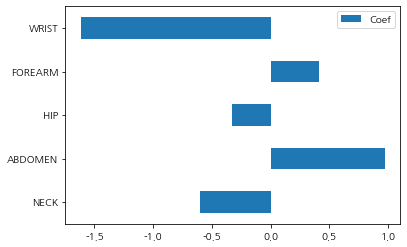

In [21]:
# 설명변수 중요도(표준화 하기 전)[coef값]
df_reg_coef = pd.DataFrame({"Coef": rfe_reg_result.params.values[1:]}, \
                          index = selected_cols)
df_reg_coef.plot.barh(y = "Coef", legend = True)

In [23]:
## 회귀계수의 표준화 진행

# 설명변수 표준화 적용
scaler = StandardScaler()

cols = df_raw_x.columns

np_scaled = scaler.fit_transform(df_raw_x)
df_scaled = pd.DataFrame(np_scaled, columns = cols)

df_scaled["FAT"] = df_raw["FAT"]
reg_model_scaled = smf.ols(formula = "FAT ~ NECK + ABDOMEN + HIP + FOREARM \
                                        +WRIST", data = df_scaled)

reg_result_scaled = reg_model_scaled.fit()
print(reg_result_scaled.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     133.8
Date:                Tue, 02 Mar 2021   Prob (F-statistic):           4.38e-68
Time:                        10:29:49   Log-Likelihood:                -726.92
No. Observations:                 252   AIC:                             1466.
Df Residuals:                     246   BIC:                             1487.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     19.1508      0.276     69.362      0.0

<AxesSubplot:>

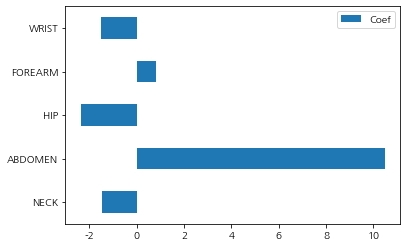

In [24]:
# 설명변수 중요도 (표준화 후)
df_reg_coef = pd.DataFrame({"Coef": reg_result_scaled.params.values[1:]}, \
                          index = selected_cols)
df_reg_coef.plot.barh(y = "Coef", legend = True)

※ WRIST가 더 높은 coef를 보여줬지만, 단위 표준화 후에는 ABDOMEN이 더 높은 coef를 보여준다.